Credits: https://github.com/GiuseppeMoscarelli/Tesi_Associative_Classifier/blob/main/Pattern_extraction/Full_almostFull.ipynb

In [1]:
import time
#start = time.time()
#IMPORTS
from datetime import datetime
from pyspark.ml.fpm import PrefixSpan
from pyspark.sql import Row
import pyspark.sql.functions as F
from math import sin, cos, sqrt, atan2, radians 
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import operator
import os


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
#parameters
support = 0.05
interval = 30 #time window
maxDelta = 3 #how many spatial deltas
th = 0.5 #distance (seems in km)
window_size = 3 #how many time deltas

In [3]:
#FILES
inputPath  = "bike_sharing/filtered_status.csv"
STATION_PATH = "bike_sharing/station.csv"
#output files
folder_path = f'../../Results/Extraction/Full-AlmostFull/Full-AlmostFull_{interval}_{int(th*1000)}_{support}({window_size}-{maxDelta})'

output_file = f'{folder_path}/results_{int(th*1000)}_{support}_ordered_by_confidence.txt'
output_file2 = f'{folder_path}/results_{int(th*1000)}_{support}_AlmostFull-Full_ordered_by_confidence.txt'
output_file3 = f'{folder_path}/results_{int(th*1000)}_{support}_diff_delta_ordered_by_confidence.txt'
output_file4 = f'{folder_path}/results_{int(th*1000)}_{support}_ordered_by_support.txt'
output_file5 = f'{folder_path}/results_{int(th*1000)}_{support}_AlmostFull-Full_ordered_by_support.txt'
output_file6 = f'{folder_path}/results_{int(th*1000)}_{support}_diff_delta_ordered_by_support.txt'
img_support = f'{folder_path}/{window_size}-{maxDelta}-{int(th*1000)}-{support}-{interval}.jpg'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

In [4]:
inputDF = spark.read.format("csv")\
.option("delimiter", ",")\
.option("header", True)\
.option("inferSchema", True).load(inputPath)

In [5]:
inputDF = inputDF.filter("bikes_available is not null")

In [6]:
#filter for these fields
filteredDF = inputDF.filter("docks_available<>0 OR bikes_available<>0")

In [7]:
#determine if the station is full or almost full

'''
state = 0 -> 0 docks available
state = 1 -> docks available = 1 or 2
state = 2 -> otherwise
It is an hardcoded parameter for "almost" condition
'''

def stateFunction(docks_available, bikes_available):
    if docks_available==0:
        return 1
    elif (docks_available==1 or docks_available==2):
        return 0
    else:
        return 2

spark.udf.register("state", stateFunction)

<function __main__.stateFunction(docks_available, bikes_available)>

In [8]:
def getInt(station):
    return (station)

spark.udf.register("intValue", getInt)

<function __main__.getInt(station)>

In [9]:
getStatusDF = filteredDF.selectExpr("station_id", "time", "state(docks_available, bikes_available) as status")

In [10]:
#filter only full or almost full stations
full_almostFull = getStatusDF.filter("status==1  or status==0")

In [11]:
full_almostFull_count = full_almostFull.count()
print(full_almostFull_count/getStatusDF.count()*100)

3.269968522286907


In [12]:
#create a view
full_almostFull.createOrReplaceTempView("readings")

In [13]:
#select station, year, month, day, hour, minute, status ordered by time

ss = spark.sql(
"""
SELECT  station_id , YEAR(time) as year, MONTH(time) as month, DAY(time) as day, HOUR(time)as hour, MINUTE(time) as minute, status
FROM readings
GROUP BY station_id, year, month, day, hour, minute, status
ORDER BY  station_id, year, month, day, hour, minute
""")

In [14]:
#create rdd and group into interval

my_rdd = ss.rdd.map(tuple)
rdd = my_rdd.map(lambda line: (line[0], line[1], line[2], line[3], line[4], int(line[5]/interval), line[6])).distinct()

In [15]:
#rdd.collect()

In [16]:
#get distinct stations to calculate distances
id_stations = rdd.map(lambda line: line[0]).distinct()

In [17]:
tot_id_stations = id_stations.collect() # all distinct station ids

In [18]:
#obtain timestamp and info

def getMap(line):
    id_station = str(line[0])
    year = int(line[1])
    month = int(line[2])
    day = int(line[3])
    hour = int(line[4])
    minute = int(line[5])   
    timestamp = datetime(year, month, day, hour, minute)  
    status = int(line[6])
    if status==0:
        status='AlmostFull'
    else:
        status='Full'
    info = id_station.split('.')[0]+'_'+status
    return ((timestamp, info))

get_map = rdd.map(getMap)

In [19]:
#get_map.collect()

In [20]:
#for each timestamp obtain info
reduceK = get_map.reduceByKey(lambda l1, l2 :(l1+','+l2)).sortByKey()

In [21]:
my_df = reduceK.toDF()

In [22]:
#my_df.collect()

In [23]:
my_df.createOrReplaceTempView("view")

In [24]:
s2 = spark.sql("""
SELECT ROW_NUMBER() 
OVER(ORDER BY _1,_2) as id ,_1, _2
FROM view 
""")

In [25]:
#identifier of the timestamp, info
rdd_scheme = s2.rdd.map(tuple).map(lambda line: (line[0], line[2]))

In [26]:
#obtain window, station-status
def giveSplit(line):   
    id_window = (int(line[0]))
    lista = []
    counter = id_window    
    while counter >= 1:
        lista.append(('Window '+ str(counter), (line[1])))
        counter = counter-1
        if(id_window-counter)==window_size:
            return lista  
    return lista

mapData = rdd_scheme.flatMap(giveSplit)

In [27]:
# for each window get all info
all_keys = mapData.reduceByKey(lambda l1,l2:(l1+'-'+l2))

In [28]:
#finestra temporale
def reduceKeys(line):   
    lista=[]
    #lista.append(line[0])
    line_split=line[1].split("-")
    #return line_split[0]
    count=len(line_split)
    tot=[]
    for val in range(count):
        li=[]
        stations=line_split[val].split(',')
        for st in stations:
            all_string_st=st.split('_')[0]+'_'+'T'+str(val)+'_'+st.split('_')[1]
            li.append(all_string_st)
        tot.append(li)
    lista.append((line[0],(tot))) 
    return lista

windows = all_keys.flatMap(reduceKeys)

In [29]:
#load station file
stationsDF = spark.read.format("csv")\
.option("delimiter", ",")\
.option("header", True)\
.option("inferSchema", True).load(STATION_PATH)

In [30]:
#get only rows of interest: only the used stations 
necessary_rows = stationsDF.filter(F.col("id").isin(tot_id_stations)).sort("id").rdd.map(tuple)

In [31]:
# print(len(stationsDF.collect()), len(necessary_rows.collect()))
# output: 70 68

In [32]:
#get info of stations about coordinates and name
coordinates = necessary_rows.map(lambda line: (line[0],(str(line[2])+','+str(line[3]))))
names_stations = necessary_rows.map(lambda line: (line[0],line[1]))
list_coo=coordinates.collect()

In [33]:
#create a dictionary in which the key is the station and value is the info about coordinates
dic_co = coordinates.collectAsMap()
dic_coordinates = sc.broadcast(dic_co)

In [34]:
#function to retrieve distance between 2 stations
def getDistance(station1, station2):
    # approximate radius of earth in km
    R = 6373.0    
    lat_a=float(station1.split(',')[0])
    lat_b=float(station2.split(',')[0])
    long_a=float(station1.split(',')[1])
    long_b=float(station2.split(',')[1])
    
    lat1=radians(lat_a)
    lat2=radians(lat_b)
    lon1=radians(long_a)
    lon2=radians(long_b)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [35]:
#dict in which the key is a pair of stations and value is the distance
dict_distances={}
for i in range(len(list_coo)):
    for j in range(i+1,len(list_coo)):
        station1=list_coo[i][0]
        station2=list_coo[j][0]
        d_i=list_coo[i][1]
        d_j=list_coo[j][1]
        distance=getDistance(d_i,d_j)
        id_stations=str(station1)+' '+str(station2)
        dict_distances[id_stations]=distance

In [36]:
#Apply “Spatial Delta”
def giveSpatialWindow(line):
    lista=[]    
    time0=line[1][0]    
    dic={}
    
    count_windows=len(line[1])#tot windows

    for station in time0:# only first window
        current_station=int(station.split('_')[0])
        #lista_station=[] 
        list_tmp=[]
        
        #for each window
        for i, window in enumerate(line[1]):           
            second_lista=[]
            #for each element of a window
            for item in window :
                #second_lista=[]
                second_station=int(item.split('_')[0])
                state=item.split('_')[2]
               
                if current_station!=second_station:
                    if current_station<second_station:
                        key=str(current_station)+' '+str(second_station)
                    else:
                        key=str(second_station)+' '+str(current_station)                    
                    
                    dist=dict_distances[key]
                    if dist<=maxDelta*th:
                        delta=0
                        for d in range(1,maxDelta+1):
                            if d*th>=dist:
                                delta=d
                                break                        
                        label=state+'_'+'T'+str(i)+'_'+str(delta)
                        second_lista.append(label)
                else:
                    label=state+'_'+'T'+str(i)+'_'+str(0)
                    second_lista.append(label)
                    
            if len(second_lista)>0:
                list_tmp.append(second_lista)
        lista.append(((line[0]+'|'+str(current_station)),list_tmp))
    
    return lista

spatial_app = windows.flatMap(giveSpatialWindow)

In [37]:
def row_seq(line):
    true=line[1]
    string=Row(sequence=true)
    return string

spatial = spatial_app.map(row_seq)

In [38]:
#create a dataframe
df = spatial.toDF()
print(df.count())
df.show(20, False)

114705
+-------------------------------------------------------------------------------+
|sequence                                                                       |
+-------------------------------------------------------------------------------+
|[[AlmostFull_T0_0, AlmostFull_T0_3, Full_T0_3], [AlmostFull_T1_3, Full_T1_3]]  |
|[[AlmostFull_T0_0], [AlmostFull_T1_0, Full_T1_0], [AlmostFull_T2_0]]           |
|[[AlmostFull_T0_3, AlmostFull_T0_0, Full_T0_0], [AlmostFull_T1_0, Full_T1_0]]  |
|[[AlmostFull_T0_3, AlmostFull_T0_0, Full_T0_0], [AlmostFull_T1_0, Full_T1_0]]  |
|[[AlmostFull_T0_0, Full_T0_0], [AlmostFull_T1_0], [AlmostFull_T2_0]]           |
|[[AlmostFull_T0_0, Full_T0_0], [AlmostFull_T2_3]]                              |
|[[AlmostFull_T0_0, Full_T0_0], [AlmostFull_T2_3]]                              |
|[[AlmostFull_T0_0, Full_T0_0], [AlmostFull_T1_0], [AlmostFull_T2_0]]           |
|[[AlmostFull_T0_0], [AlmostFull_T1_0], [Full_T2_0, AlmostFull_T2_0]]           |
|[[Almost

In [39]:
#prefixspan to obtain sequence and frequence
supports = [support]
counter=[]
for support in supports:
    print(support)
    prefixSpan = PrefixSpan(minSupport=support, maxPatternLength=5,
                        maxLocalProjDBSize=5000)
    prefix=prefixSpan.findFrequentSequentialPatterns(df)   
    len_prefix=prefix.count()    
    prefix.show(len_prefix, False)
    counter.append(len_prefix)

0.05
+-------------------------------------------------------------------------------------------+------+
|sequence                                                                                   |freq  |
+-------------------------------------------------------------------------------------------+------+
|[[AlmostFull_T2_2]]                                                                        |29810 |
|[[Full_T1_2]]                                                                              |8502  |
|[[AlmostFull_T0_2]]                                                                        |29298 |
|[[Full_T2_3]]                                                                              |11926 |
|[[AlmostFull_T1_1]]                                                                        |19302 |
|[[Full_T2_0]]                                                                              |19233 |
|[[AlmostFull_T0_1]]                                                                  

In [40]:
counter

[880]

In [41]:
pre = prefix.rdd.map(tuple)

In [42]:
def giveSelected(line):
    seq=line[0]
    found=False   
    for window in seq:
        for el in window:
            if 'T0' in el and '_0' in el:
                found=True
                break
    return found 

giveT0 = pre.filter(giveSelected)

In [43]:
df2 = giveT0.toDF().withColumnRenamed('_1','sequence')
df2 = df2.withColumnRenamed('_2','freq')#.show(len_prefix,False)

In [44]:
def mapValues(line):
    seq=line[0]
    final=''
    #dict[seq]=line[1]
    for i, window in enumerate(seq):
        if i>0:
            final+='-'
        for j, el in enumerate(window):
            if j>0:
                final+=','
            final+=el
    final+=(';'+str(line[1])+';'+str(i))
    return final  

mapDict = giveT0.map(mapValues)

In [45]:
li = mapDict.collect()
dic = {}
for el in li:
    splits = el.split(';')
    dic[splits[0]] = int(splits[1])

In [46]:
repeated_el_window=0

for el in dic.keys():
    flag_rep=False
    windows=el.split('-')
    for w in windows:
        tot_items=len(w.split(','))
        set_items=len(set(w.split(',')))
        if tot_items!=set_items:
            repeated_el_window+=1
            break
repeated_el_window

29

In [47]:
dic_supports={}
for el in dic.keys():    
    if len(el.split('-'))>1:        
        num=int(dic[el])       
        string=''
        tot=el.split('-')[:-1]
        for k,station in enumerate(tot):
            if k>0:
                string+='-'
            string+=station
        #print(string)
        den=int(dic[string])
        dic_supports[el]=str(num/den)+' - '+str(dic[el])
keys = list(dic_supports.keys())
values = list(dic_supports.values())

#sort dictionary by decreasing values and sort within each window
for key in dic_supports:    
    splitted=key.split('-')      
    splitted.sort()
# dic_supports = dict(sorted(dic_supports.items(), key=operator.itemgetter(1),reverse=True))
dic_supports = dict(sorted(dic_supports.items(), 
                           key=lambda v: (float(v[1].split(' - ')[0]), int(v[1].split(' - ')[1])),
                           reverse=True))

In [48]:
# output_file='results_..._ordered_by_confidence.txt'

file = open(output_file, "w")
list_pattern=[]
for el in dic_supports:
    key_list=[]
    for e in el.split('-'):
        key_list.append([e])
    list_pattern.append([[key_list], [dic_supports[el]]])
file.write('Pattern, Confidence-Frequence'+'\n')
file.write(f'Total number of input patterns: {len(dic_supports)}'+'\n')
for el in list_pattern:  
    file.write(str(el)+ '\n')    
file.close() 

In [49]:
# output_file4='results_..._ordered_by_support.txt'
file4 = open(output_file4, "w")
#order list fist by support and then by confidence
list_ordered_by_support = sorted(list_pattern,
                                 key=lambda v: (int(v[1][0].split(" - ")[1]), float(v[1][0].split(" - ")[0])),
                                 reverse=True)
file4.write('Pattern, Confidence-Frequence'+'\n')
file4.write(f'Total number of input patterns: {len(dic_supports)}'+'\n')
for el in list_ordered_by_support:  
    file4.write(str(el)+ '\n')    
file4.close()

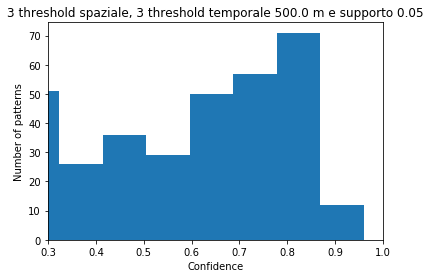

In [50]:
tot_list=[]
for i, j in zip(keys,values):
    key_list=[]
    for el in i.split('-'):
        key_list.append([el])
    tot_list.append([[key_list], [j]])
confidence=[]
for el in values:
    val=round(float(el.split(' - ')[0]),2)
    confidence.append(val)
#confidence    
plt.hist(confidence)
plt.xlabel('Confidence')
plt.ylabel('Number of patterns')
plt.title(f'{maxDelta} threshold spaziale, {window_size} threshold temporale {th*1000} m e supporto {support}')
plt.xlim(0.3,1)
plt.savefig(img_support)
plt.show()

In [51]:
#how many min, max, avg items there are
num_items=0
num_freq_items=0
min_items=sys.maxsize
max_items=0
avg_items=0

num_freq_window=0
tot_window=0
num_patterns=0
min_window=sys.maxsize
max_window=0
avg_window=0
flag_piena=False
flag_quasi_piena=False

list_piena_quasi_piena=[]

for key in dic_supports.keys():
    flag_piena=False
    flag_quasi_piena=False    
    string=''
    
    #statistics for the windows
    if '-' in key:
        patterns=len(key.split('-'))
        tot_window+=patterns      
    else:
        tot_window+=1
        patterns=1
    num_patterns+=1
    
    #statistics for the ìtems
    if ('-' in key and ',' in key):
        new_key=key       
        new_key=new_key.replace(',', '-')               
        items=new_key.split('-')
        for el in items:
            string+=el.split('_')[0]
            if el.split('_')[0].startswith('Full') and flag_piena==False:
                flag_piena=True
            elif el.split('_')[0].startswith('AlmostFull') and flag_quasi_piena==False:
                flag_quasi_piena=True
      
       
    elif ('-' in key):
        items=key.split('-')
        for el in items:
            string+=el.split('_')[0]
            if el.split('_')[0].startswith('Full') and flag_piena==False:
                flag_piena=True
            elif el.split('_')[0].startswith('AlmostFull') and flag_quasi_piena==False:
                flag_quasi_piena=True
       
    elif ( ',' in key):
        items=key.split(',')
        for el in items:
            string+=el.split('_')[0]
            if el.split('_')[0].startswith('Full') and flag_piena==False:
                flag_piena=True
            elif el.split('_')[0].startswith('AlmostFull') and flag_quasi_piena==False:
                flag_quasi_piena=True
      
    else:
        items=list(key)
        for el in items:
            string+=el.split('_')[0]
            if el.split('_')[0].startswith('Full') and flag_piena==False:
                flag_piena=True
            elif el.split('_')[0].startswith('AlmostFull') and flag_quasi_piena==False:
                flag_quasi_piena=True
    if (flag_quasi_piena==True and flag_piena==True):       
        #list_piena_quasi_piena.append([key])
        key_list=[]            
        for e in key.split('-'):
            key_list.append([e])
        list_piena_quasi_piena.append([[key_list], [dic_supports[key]]])

    q_items=len(items) 
    if min_items>q_items:
        min_items=q_items
    if max_items<q_items:
        max_items=q_items
    freq=int(dic_supports[key].split('-')[1])
    num_items+=freq 
    num_freq_items+=freq*q_items
    
    if min_window> patterns:
        min_window=patterns
    if max_window<patterns:
        max_window=patterns    
    num_freq_window+=freq*patterns  

avg_window=0
if num_items!=0:
    avg_items=float(num_freq_items)/float(num_items)    
    print(f'The average number of items is: {avg_items}')    
    avg_window=float(num_freq_window)/ float(num_items)
    print(f'The average number of windows is: {avg_window}')
else:
    print(f'The average number of windows is: {avg_window}')
    
print(f'The minimum number of items is: {min_items}')
print(f'The maximum number of items is: {max_items}')
print(f'The minimum number of windows is: {min_window}')
print(f'The maximum number of windows is: {max_window}')

The average number of items is: 3.6008386725055996
The average number of windows is: 2.5102399301772893
The minimum number of items is: 2
The maximum number of items is: 5
The minimum number of windows is: 2
The maximum number of windows is: 3


In [52]:
# output_file2='results_..._QuasiPiena_Piena_ordered_by_confidence.txt'
file2 = open(output_file2, "w")
# lung_piena_quasipiena=0
if len(list_piena_quasi_piena)!=0:
    df_supports=sc.parallelize(list_piena_quasi_piena).toDF().withColumnRenamed('_1','sequence')
    df_supports=df_supports.withColumnRenamed('_2','confidence-freq')
    lung_piena_quasipiena=df_supports.count() 
#     df_supports.show(lung_piena_quasipiena,False)
#     print(lung_piena_quasipiena)
#list_piena_quasi_piena
file2.write('Pattern, Confidence-Frequence'+'\n')
file2.write(f'Total number of input patterns: {len(list_piena_quasi_piena)}'+'\n')
if len(list_piena_quasi_piena)!=0:
    for el in list_piena_quasi_piena:
        #print(el)
        file2.write(str(el)+'\n')
file2.close()

In [53]:
# output_file5='results_..._QuasiPiena_Piena_ordered_by_support.txt'
file5 = open(output_file5, "w")
#order list fist by support an then by confidence
list_piena_quasi_piena_ordered_by_support = sorted(list_piena_quasi_piena,
                                                   key=lambda v: (int(v[1][0].split(" - ")[1]), float(v[1][0].split(" - ")[0])),
                                                   reverse=True)
file5.write('Pattern, Confidence-Frequence'+'\n')
file5.write(f'Total number of input patterns: {len(list_piena_quasi_piena_ordered_by_support)}'+'\n')
if len(list_piena_quasi_piena_ordered_by_support)!=0:
    for el in list_piena_quasi_piena_ordered_by_support:
        #print(el)
        file5.write(str(el)+'\n')
file5.close()

In [54]:
list_influenze=[]
for el in dic_supports.keys():
    delta_spaziale=False
    if ('-' in el):
        all_windows_list=el.split('-')
        if ('T0_0' in all_windows_list[0] ):
            for cons_window in all_windows_list[1::]:
                if ',' in cons_window:
                    for item in cons_window.split(','):                       
                        act_delta=int(item.split('_')[2])
                        if act_delta!=0:
                            delta_spaziale=True
    if delta_spaziale==True:        
        key_list=[]            
        for e in el.split('-'):
            key_list.append([e])
        list_influenze.append([[key_list], [dic_supports[el]]])
# output_file3='results_..._diff_delta_ordered_by_confidence.txt'
file3 = open(output_file3, "w")
lung_different_time_space=0
if len(list_influenze)!=0:
    df_supports=sc.parallelize(list_influenze).toDF().withColumnRenamed('_1','sequence')
    df_supports=df_supports.withColumnRenamed('_2','confidence-freq')
    lung_different_time_space=df_supports.count() 
    #df_supports.show(lung_different_time_space,False)
    #print(lung_different_time_space)
file3.write('Pattern, Confidence-Frequence'+'\n')
file3.write(f'Total number of input patterns: {len(list_influenze)}'+'\n')
if len(list_influenze)!=0:
    for el in list_influenze:       
        file3.write(str(el)+'\n')
file3.close()

In [55]:
# output_file6='results_..._diff_delta_ordered_by_support.txt'
file6 = open(output_file6, "w")
#order list first by support and then by confidence
list_influenze_ordered_by_support = sorted(list_influenze,
                                           key=lambda v: (int(v[1][0].split(" - ")[1]), float(v[1][0].split(" - ")[0])),
                                           reverse=True)
file6.write('Pattern, Confidence-Frequence'+'\n')
file6.write(f'Total number of input patterns: {len(list_influenze_ordered_by_support)}'+'\n')
if len(list_influenze_ordered_by_support)!=0:
    for el in list_influenze_ordered_by_support:       
        file6.write(str(el)+'\n')
file6.close()

In [56]:
lung_piena_quasipiena=0
if len(list_piena_quasi_piena)!=0:
    df_supports=sc.parallelize(list_piena_quasi_piena).toDF().withColumnRenamed('_1','sequence')
    df_supports=df_supports.withColumnRenamed('_2','confidence-freq')
    lung_piena_quasipiena=df_supports.count() 
    df_supports.show(lung_piena_quasipiena,False)
    print(lung_piena_quasipiena)

+-------------------------------------------------------------------------------------+-----------------------------+
|sequence                                                                             |confidence-freq              |
+-------------------------------------------------------------------------------------+-----------------------------+
|[[[AlmostFull_T0_3,Full_T0_0], [AlmostFull_T1_3,Full_T1_0], [AlmostFull_T2_3]]]      |[0.8741078208048595 - 5756]  |
|[[[Full_T0_0], [AlmostFull_T1_3,Full_T1_0], [AlmostFull_T2_3]]]                      |[0.8720855339430632 - 6770]  |
|[[[AlmostFull_T0_3,Full_T0_0], [AlmostFull_T1_0,AlmostFull_T1_3], [AlmostFull_T2_3]]]|[0.8573834924199888 - 6108]  |
|[[[AlmostFull_T0_0,Full_T0_0], [AlmostFull_T1_0,AlmostFull_T1_3], [AlmostFull_T2_3]]]|[0.8572134387351779 - 6940]  |
|[[[Full_T0_0], [AlmostFull_T1_0,AlmostFull_T1_3], [AlmostFull_T2_3]]]                |[0.8571758991557765 - 7412]  |
|[[[AlmostFull_T0_3,Full_T0_0], [AlmostFull_T1_3], [Almo

In [57]:
print(f'The number of patterns in the pre-filter is: {len_prefix}')
print(f'The number of items after the filter with at least 2 windows and at least a T0 and delta 0 is: {len(dic_supports)}')
print('STATISTICS about sequences with at least 2 windows_T0_delta0')
print(f'The average number of windows is: {avg_window}')
print(f'The minimum number of windows is: {min_window}')
print(f'The maximum number of windows is: {max_window}')
print(f'The average number of items is: {avg_items}')
print(f'The minimum number of items is: {min_items}')
print(f'The maximum number of items is: {max_items}')
print(f'The number of patterns in which there is at least one item that repeats within a window is: {repeated_el_window} ')
print(f'The number of patterns with at least 1 event AlmostFull and 1 event Full is: {lung_piena_quasipiena}')
print(f'The number of patterns with at least 1 T0, DELTA S=0 and at least 1 pattern with at least 1 pattern with DELTA S different from 0 and DELTA T different from 0 is: {lung_different_time_space}')


The number of patterns in the pre-filter is: 880
The number of items after the filter with at least 2 windows and at least a T0 and delta 0 is: 437
STATISTICS about sequences with at least 2 windows_T0_delta0
The average number of windows is: 2.5102399301772893
The minimum number of windows is: 2
The maximum number of windows is: 3
The average number of items is: 3.6008386725055996
The minimum number of items is: 2
The maximum number of items is: 5
The number of patterns in which there is at least one item that repeats within a window is: 29 
The number of patterns with at least 1 event AlmostFull and 1 event Full is: 186
The number of patterns with at least 1 T0, DELTA S=0 and at least 1 pattern with at least 1 pattern with DELTA S different from 0 and DELTA T different from 0 is: 204
